# Inference: Relativistic Monte Carlo

This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using [Relativistic MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/relativistic_mcmc.html).


First, we create a simple normal distribution

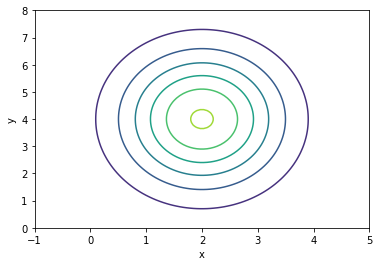

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up and run a sampling routine using Relativistic MCMC.

In [2]:
# Choose starting points for 3 mcmc chains
xs = [
    [2, 1],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
sigma = [1, 1]
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.RelativisticMCMC, sigma0=sigma)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Relativistic MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     63     0.333     0.333     0.333      0:00.1
2     123    0.5       0.5       0.5        0:00.1
3     183    0.6       0.6       0.6        0:00.1
100   6003   0.98      0.98      0.98       0:00.3
200   12003  0.990099  0.990099  0.990099   0:00.6
300   18003  0.993     0.993     0.993      0:00.8
400   24003  0.995     0.995     0.995      0:01.1
500   30003  0.996     0.996     0.996      0:01.3
600   36003  0.997     0.997     0.995      0:01.5
700   42003  0.997151  0.997151  0.996      0:01.8
800   48003  0.998     0.998     0.996      0:02.0
900   54003  0.998     0.998     0.997      0:02.3
1000  59943  0.997003  0.998002  0.997003   0:02.5
Halting: Maximum number of iterations (1000) reached.
Done!


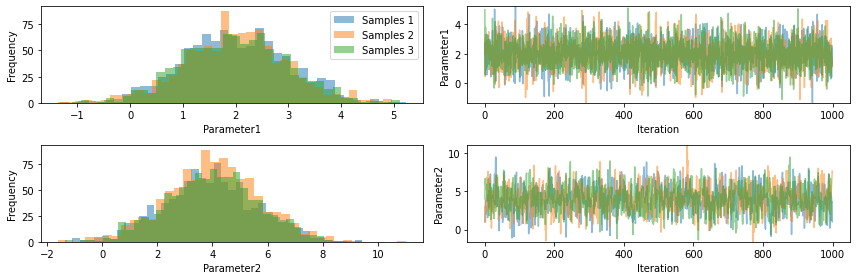

In [3]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mean_x   1.99    0.99    0.04    1.32   1.98   2.63   3.93     1.00    800.00  319.58
mean_y   4.01    1.69    0.76    2.88   4.03   5.10   7.30     1.00    552.37  220.66


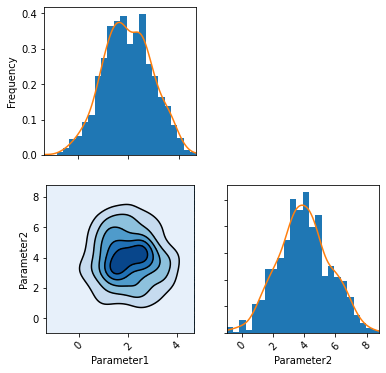

0.002097160049395974
0.0020671312230795547
0.002779386914368409


In [4]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['mean_x', 'mean_y'])
print(results)

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

## Relativistic Monte Carlo on a time-series problem

We now try the same method on a time-series problem

In [5]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
times = np.linspace(0, 1000, 50)
real_parameters = np.array([0.015, 500])
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Relativistic MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     63     0.333     0.333     0.333      0:00.1
2     123    0.5       0.5       0.5        0:00.1
3     183    0.6       0.6       0.6        0:00.1
100   6003   0.98      0.98      0.98       0:00.6
200   12003  0.990099  0.990099  0.990099   0:01.2
300   18003  0.993     0.993     0.993      0:01.8
400   24003  0.995     0.995     0.995      0:02.3
500   30003  0.996     0.996     0.994      0:02.8
600   36003  0.995     0.997     0.995      0:03.4
700   42003  0.993     0.997151  0.996      0:04.0
800   48003  0.994     0.996     0.995      0:04.5
900   54003  0.992     0.997     0.996      0:05.1
1000  59943  0.992008  0.996004  0.996004   0:05.7
Halting: Maximum number of iterations (1000) reached.
Done!


The chains do not take long to reach equilibrium with this method.

param        mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-----------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
growth rate  0.01    0.00    0.01    0.01    0.01    0.02    0.02     1.00    800.00  141.53
capacity     500.61  2.34    496.05  498.94  500.59  502.33  505.07   1.01    566.15  100.16


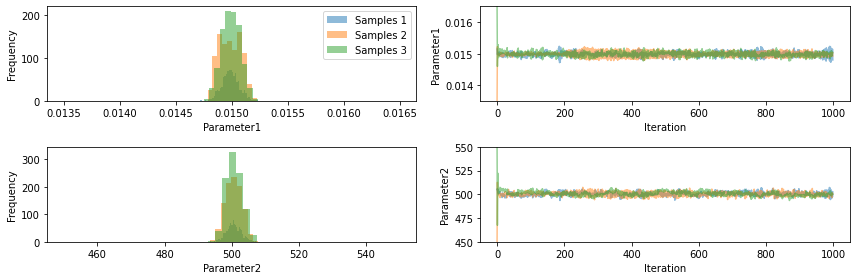

In [6]:
# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains[:, 200:], time=mcmc.time(), parameter_names=['growth rate', 'capacity'])
print(results)

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

Chains have converged!

Extract any divergent iterations -- looks fine as there were none.

In [7]:
div = len(mcmc.samplers()[0].divergent_iterations())
print("There were " + str(div) + " divergent iterations in the 1st chain.")

There were 0 divergent iterations in the 1st chain.
